# 1. Build (implement) Decision Tree classifiers (ID3 and CART)
###  Visualize the decision tree structures for both algorithms.
###  Evaluate and compare the performance of both ID3 and CART decision trees, using evaluation metrics.

ID3 Training Accuracy: 97.5000
ID3 Testing Accuracy: 93.3333


<Figure size 640x480 with 0 Axes>

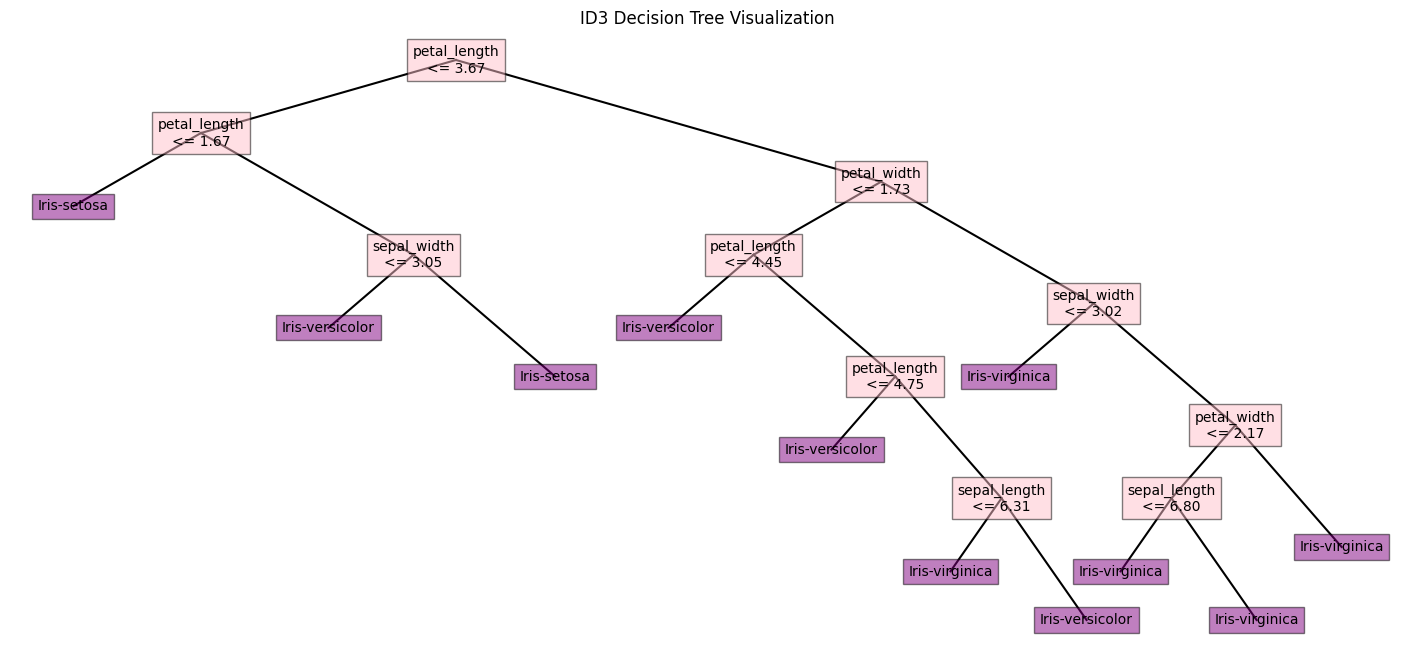

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Iris dataset
iris_data = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Split the dataset into training and testing sets
train_dataset = iris_data.sample(frac=0.8, random_state=42)
test_dataset = iris_data.drop(train_dataset.index)

def calculate_entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return -np.sum(probabilities * np.log2(probabilities))

def calculate_information_gain(features, labels, feature, threshold=None):
    if threshold is not None:
        left_mask = features[feature] <= threshold
        left_entropy = calculate_entropy(labels[left_mask])
        right_entropy = calculate_entropy(labels[~left_mask])
        n = len(labels)
        n_left = sum(left_mask)
        n_right = n - n_left
        return calculate_entropy(labels) - (n_left / n) * left_entropy - (n_right / n) * right_entropy
    return calculate_entropy(labels) - sum(len(v) / len(labels) * calculate_entropy(v) for _, v in labels.groupby(features[feature]))

def find_optimal_split(features, labels):
    best_gain = -1
    best_feature = None
    best_threshold = None

    for feature in features.columns:
        threshold = features[feature].mean()
        gain = calculate_information_gain(features, labels, feature, threshold)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_threshold = threshold

    return best_feature, best_threshold, best_gain

def build_id3_tree(features, labels, max_depth=5, min_samples_split=2, min_info_gain=0.0, depth=0):
    if len(labels) < min_samples_split or depth >= max_depth or len(np.unique(labels)) == 1:
        return {'label': labels.mode().iloc[0]}

    feature, threshold, info_gain = find_optimal_split(features, labels)

    if info_gain <= min_info_gain:
        return {'label': labels.mode().iloc[0]}

    left_mask = features[feature] <= threshold
    right_mask = ~left_mask

    left_tree = build_id3_tree(features[left_mask], labels[left_mask], max_depth, min_samples_split, min_info_gain, depth + 1)
    right_tree = build_id3_tree(features[right_mask], labels[right_mask], max_depth, min_samples_split, min_info_gain, depth + 1)

    return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}

def classify_sample(node, sample):
    while 'label' not in node:
        if sample[node['feature']] <= node['threshold']:
            node = node['left']
        else:
            node = node['right']
    return node['label']

def classify(tree, features):
    return features.apply(lambda x: classify_sample(tree, x), axis=1)

def evaluate_model(tree, features, labels):
    predictions = classify(tree, features)
    accuracy = (predictions == labels).mean()
    return accuracy

decision_tree = build_id3_tree(train_dataset.drop('species', axis=1), train_dataset['species'], max_depth=5)

train_accuracy = evaluate_model(decision_tree, train_dataset.drop('species', axis=1), train_dataset['species'])
test_accuracy = evaluate_model(decision_tree, test_dataset.drop('species', axis=1), test_dataset['species'])

print(f"ID3 Training Accuracy: {train_accuracy * 100:.4f}")
print(f"ID3 Testing Accuracy: {test_accuracy * 100:.4f}")

def visualize_tree(node, depth=0, pos=None, ax=None):
    i = 1
    if pos is None:
        pos = [0.2, 0.2]
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 8))
        ax.axis('off')  # Turn off the axis for a cleaner look

    # Plot the text boxes after the lines to ensure lines are in the background
    if 'label' in node:
        ax.text(pos[0], pos[1], str(node['label']), 
                bbox=dict(facecolor='purple', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=10, zorder=2)
    else:
        i += 1
        ax.text(pos[0], pos[1], f'{node["feature"]}\n<= {node["threshold"]:.2f}', 
                bbox=dict(facecolor='pink', alpha=0.5),
                horizontalalignment='center', verticalalignment='center', fontsize=10, zorder=2)

        # Define positions for left and right child nodes
        pos_left = [pos[0] - 0.15 / (depth + 1), pos[1] - 0.15]
        pos_right = [pos[0] + 0.25 / (depth + 1), pos[1] - 0.25]

        # Plot lines connecting to child nodes with zorder=1 so they appear beneath the boxes
        ax.plot([pos[0], pos_left[0]], [pos[1], pos_left[1]], 'k-', zorder=1)
        ax.plot([pos[0], pos_right[0]], [pos[1], pos_right[1]], 'k-', zorder=1)

        # Recursively visualize left and right subtrees
        visualize_tree(node['left'], depth + 1, pos_left, ax)
        visualize_tree(node['right'], depth + 1, pos_right, ax)

# Visualize the tree
plt.figure()
visualize_tree(decision_tree)
plt.title("ID3 Decision Tree Visualization")
plt.axis('off')
plt.show()



CART Training Accuracy: 100.0000
CART Testing Accuracy: 93.3333


<Figure size 640x480 with 0 Axes>

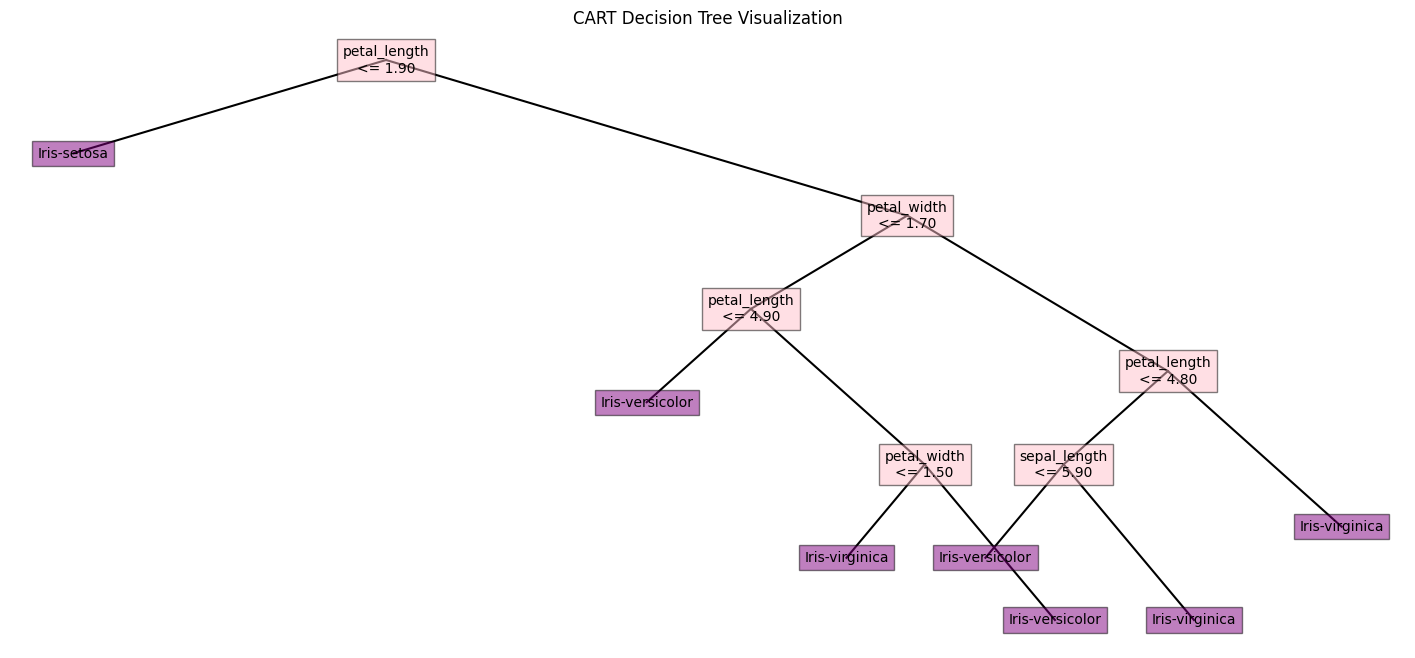

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Gini index calculation
def calculate_gini_index(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

# Best split calculation for CART
def find_best_split_cart(features, labels):
    best_gini = float('inf')
    best_feature = None
    best_threshold = None

    for feature in features.columns:
        thresholds = features[feature].unique()
        for threshold in thresholds:
            left_mask = features[feature] <= threshold
            right_mask = ~left_mask

            if len(labels[left_mask]) == 0 or len(labels[right_mask]) == 0:
                continue

            gini = (len(labels[left_mask]) / len(labels)) * calculate_gini_index(labels[left_mask]) + \
                   (len(labels[right_mask]) / len(labels)) * calculate_gini_index(labels[right_mask])

            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

# CART tree building
def build_cart_tree(features, labels, max_depth=5, min_samples_split=2, depth=0):
    if len(labels) < min_samples_split or depth >= max_depth or len(np.unique(labels)) == 1:
        return {'label': labels.mode().iloc[0]}

    feature, threshold = find_best_split_cart(features, labels)
    
    left_mask = features[feature] <= threshold
    right_mask = ~left_mask

    left_tree = build_cart_tree(features[left_mask], labels[left_mask], max_depth, min_samples_split, depth + 1)
    right_tree = build_cart_tree(features[right_mask], labels[right_mask], max_depth, min_samples_split, depth + 1)

    return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}

# Build the CART tree
cart_tree = build_cart_tree(train_dataset.drop('species', axis=1), train_dataset['species'], max_depth=5)

# Evaluate the CART tree
train_accuracy_cart = evaluate_model(cart_tree, train_dataset.drop('species', axis=1), train_dataset['species'])
test_accuracy_cart = evaluate_model(cart_tree, test_dataset.drop('species', axis=1), test_dataset['species'])

print(f"CART Training Accuracy: {train_accuracy_cart * 100:.4f}")
print(f"CART Testing Accuracy: {test_accuracy_cart * 100:.4f}")

# Plot the CART tree
plt.figure()
visualize_tree(cart_tree)
plt.title("CART Decision Tree Visualization")
plt.axis('off')
plt.show()



# 2. Build (implement) Random Forest
### Train a Random Forest on the same dataset (Iris dataset) with an optimal number of trees.
### Discuss and validate the optimal number of trees.
### Visualize your results.




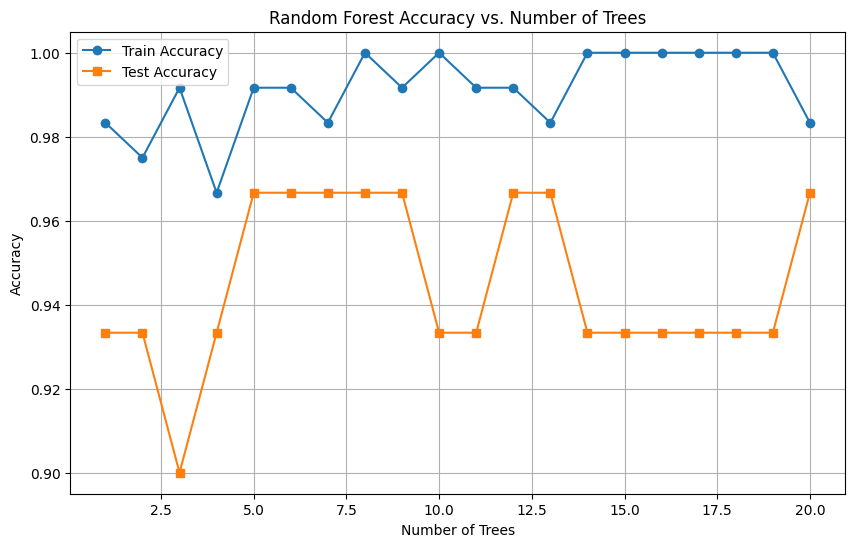

Optimal number of trees: 5
Train Accuracy with 5 trees: 99%
Test Accuracy with 5 trees: 97%


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# Load and split the Iris dataset
iris_data = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
train_dataset = iris_data.sample(frac=0.8, random_state=42)
test_dataset = iris_data.drop(train_dataset.index)

# Reuse the CART and helper functions
def calculate_gini_index(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return 1 - np.sum(probabilities ** 2)

def find_best_split_cart(features, labels):
    best_gini = float('inf')
    best_feature = None
    best_threshold = None
    for feature in features.columns:
        thresholds = features[feature].unique()
        for threshold in thresholds:
            left_mask = features[feature] <= threshold
            right_mask = ~left_mask
            if len(labels[left_mask]) == 0 or len(labels[right_mask]) == 0:
                continue
            gini = (len(labels[left_mask]) / len(labels)) * calculate_gini_index(labels[left_mask]) + \
                   (len(labels[right_mask]) / len(labels)) * calculate_gini_index(labels[right_mask])
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = threshold
    return best_feature, best_threshold

def build_cart_tree(features, labels, max_depth=5, min_samples_split=2, depth=0):
    if len(labels) < min_samples_split or depth >= max_depth or len(np.unique(labels)) == 1:
        return {'label': labels.mode().iloc[0]}
    feature, threshold = find_best_split_cart(features, labels)
    left_mask = features[feature] <= threshold
    right_mask = ~left_mask
    left_tree = build_cart_tree(features[left_mask], labels[left_mask], max_depth, min_samples_split, depth + 1)
    right_tree = build_cart_tree(features[right_mask], labels[right_mask], max_depth, min_samples_split, depth + 1)
    return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}

def classify_sample(node, sample):
    while 'label' not in node:
        if sample[node['feature']] <= node['threshold']:
            node = node['left']
        else:
            node = node['right']
    return node['label']

def classify(tree, features):
    return features.apply(lambda x: classify_sample(tree, x), axis=1)

def evaluate_model(tree, features, labels):
    predictions = classify(tree, features)
    accuracy = (predictions == labels).mean()
    return accuracy

# Random Forest Functions
def bootstrap_sample(data):
    n_samples = len(data)
    indices = np.random.choice(n_samples, n_samples, replace=True)
    return data.iloc[indices]

def random_forest_train(train_data, n_trees=10, max_depth=5, min_samples_split=2):
    trees = []
    for _ in range(n_trees):
        sample = bootstrap_sample(train_data)
        tree = build_cart_tree(sample.drop('species', axis=1), sample['species'], max_depth=max_depth, min_samples_split=min_samples_split)
        trees.append(tree)
    return trees

def random_forest_predict(trees, features):
    tree_preds = [classify(tree, features) for tree in trees]
    tree_preds = np.array(tree_preds).T
    majority_votes = [Counter(row).most_common(1)[0][0] for row in tree_preds]
    return majority_votes

# Hyperparameter Tuning: Find Optimal Number of Trees
tree_counts = range(1, 21)
train_accuracies = []
test_accuracies = []

for n_trees in tree_counts:
    forest = random_forest_train(train_dataset, n_trees=n_trees, max_depth=5)
    train_preds = random_forest_predict(forest, train_dataset.drop('species', axis=1))
    test_preds = random_forest_predict(forest, test_dataset.drop('species', axis=1))
    train_accuracy = np.mean(train_preds == train_dataset['species'])
    test_accuracy = np.mean(test_preds == test_dataset['species'])
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Visualize Accuracy vs. Number of Trees
plt.figure(figsize=(10, 6))
plt.plot(tree_counts, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(tree_counts, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

# Choose the optimal number of trees
optimal_n_trees = tree_counts[np.argmax(test_accuracies)]
# Choose the optimal number of trees
optimal_n_trees = tree_counts[np.argmax(test_accuracies)]
print(f"Optimal number of trees: {optimal_n_trees}")
print(f"Train Accuracy with {optimal_n_trees} trees: {train_accuracies[optimal_n_trees - 1] * 100:.0f}%")
print(f"Test Accuracy with {optimal_n_trees} trees: {test_accuracies[optimal_n_trees - 1] * 100:.0f}%")



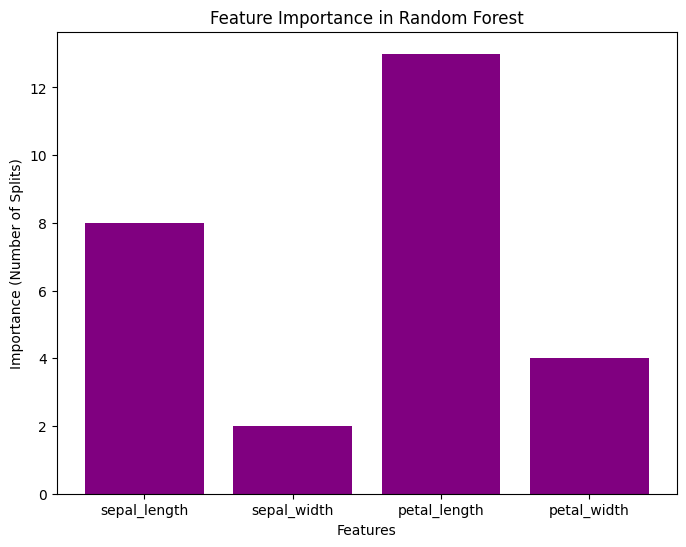

In [77]:
# Initialize a dictionary to count feature occurrences
feature_importances = {feature: 0 for feature in train_dataset.columns if feature != 'species'}

# Modified function to increment feature usage count
def build_cart_tree(features, labels, max_depth=5, min_samples_split=2, depth=0):
    if len(labels) < min_samples_split or depth >= max_depth or len(np.unique(labels)) == 1:
        return {'label': labels.mode().iloc[0]}
    feature, threshold = find_best_split_cart(features, labels)
    
    # Count the feature used for the split
    if feature in feature_importances:
        feature_importances[feature] += 1

    left_mask = features[feature] <= threshold
    right_mask = ~left_mask
    left_tree = build_cart_tree(features[left_mask], labels[left_mask], max_depth, min_samples_split, depth + 1)
    right_tree = build_cart_tree(features[right_mask], labels[right_mask], max_depth, min_samples_split, depth + 1)
    
    return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}

# Train the Random Forest with feature importance tracking
forest = random_forest_train(train_dataset, n_trees=optimal_n_trees, max_depth=5, min_samples_split=2)

# Visualize the feature importance
plt.figure(figsize=(8, 6))
plt.bar(feature_importances.keys(), feature_importances.values(), color='purple')
plt.xlabel('Features')
plt.ylabel('Importance (Number of Splits)')
plt.title('Feature Importance in Random Forest')
plt.show()


# Naive Bayes

Naïve Bayes Test Accuracy: 93.33%


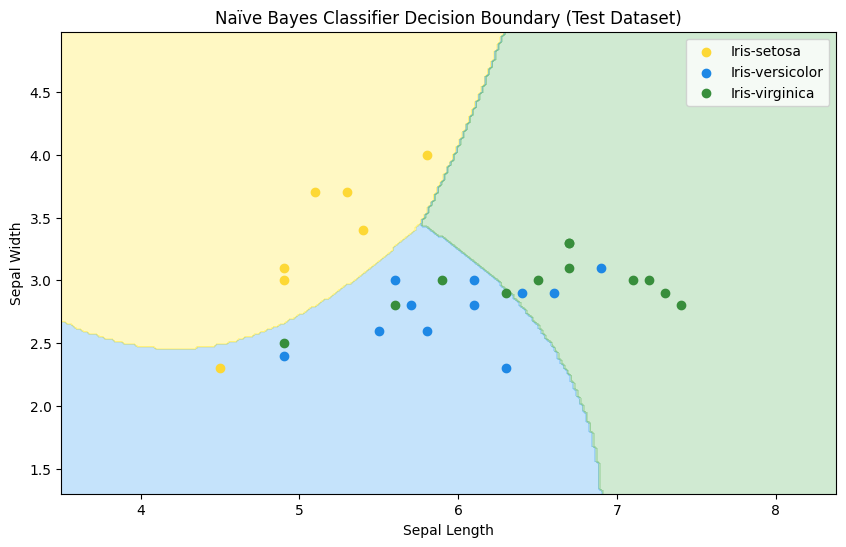

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the Iris dataset
iris_data = pd.read_csv("Iris.csv", usecols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species'])
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# Split the dataset into training and testing sets
train_data = iris_data.sample(frac=0.8, random_state=42)
test_data = iris_data.drop(train_data.index)

# Separate features and labels
X_train = train_data.drop('species', axis=1)
y_train = train_data['species']
X_test = test_data.drop('species', axis=1)
y_test = test_data['species']

# Use only two features for visualization
X_train_2d = X_train[['sepal_length', 'sepal_width']]
X_test_2d = X_test[['sepal_length', 'sepal_width']]

# Naive Bayes Classifier Implementation
class NaiveBayesClassifier:
    def __init__(self):
        self.class_prior = {}
        self.mean_var_per_class = {}

    def train(self, X_train, y_train):
        # Calculate class prior probabilities and mean/variance for each class feature
        classes = np.unique(y_train)
        for cls in classes:
            X_cls = X_train[y_train == cls]
            self.class_prior[cls] = len(X_cls) / len(y_train)
            self.mean_var_per_class[cls] = {
                'mean': X_cls.mean(),
                'var': X_cls.var()
            }
    
    def calculate_probability(self, x, mean, var):
        # Gaussian Naive Bayes probability density function
        exponent = np.exp(-(x - mean) ** 2 / (2 * var))
        return exponent / np.sqrt(2 * np.pi * var)

    def predict_single(self, x):
        probabilities = {}
        for cls, cls_data in self.mean_var_per_class.items():
            prior = np.log(self.class_prior[cls])  # log prior to avoid underflow
            likelihood = 0
            for feature in x.index:
                mean = cls_data['mean'][feature]
                var = cls_data['var'][feature]
                likelihood += np.log(self.calculate_probability(x[feature], mean, var))  # log-likelihood
            probabilities[cls] = prior + likelihood
        
        return max(probabilities, key=probabilities.get)

    def predict(self, X_test):
        return X_test.apply(self.predict_single, axis=1)

# Initialize and train Naive Bayes classifier on full feature set for accuracy evaluation
nb_classifier_full = NaiveBayesClassifier()
nb_classifier_full.train(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier_full.predict(X_test)

# Calculate accuracy
accuracy = (y_pred == y_test).mean() * 100
print(f"Naïve Bayes Test Accuracy: {accuracy:.2f}%")

# Initialize and train Naive Bayes classifier on 2D feature set for visualization
nb_classifier_2d = NaiveBayesClassifier()
nb_classifier_2d.train(X_train_2d, y_train)

# Predict on the grid for visualization
X1, X2 = np.meshgrid(
    np.arange(start=X_test_2d['sepal_length'].min() - 1, stop=X_test_2d['sepal_length'].max() + 1, step=0.02),
    np.arange(start=X_test_2d['sepal_width'].min() - 1, stop=X_test_2d['sepal_width'].max() + 1, step=0.02)
)
grid_points = pd.DataFrame(np.array([X1.ravel(), X2.ravel()]).T, columns=['sepal_length', 'sepal_width'])
Z = nb_classifier_2d.predict(grid_points)

# Encode the class labels as integers for contour plotting
class_mapping = {label: index for index, label in enumerate(np.unique(y_train))}
Z = Z.map(class_mapping).values.reshape(X1.shape)

# Visualization for Decision Boundary
plt.figure(figsize=(10, 6))
cmap_background = ListedColormap(['#FFEB3B', '#42A5F5', '#66BB6A'])
cmap_points = ListedColormap(['#FDD835', '#1E88E5', '#388E3C'])

plt.contourf(X1, X2, Z, alpha=0.3, cmap=cmap_background)

# Plot the test data points
for i, class_value in enumerate(np.unique(y_test)):
    plt.scatter(X_test_2d[y_test == class_value]['sepal_length'], 
                X_test_2d[y_test == class_value]['sepal_width'],
                color=cmap_points(i), label=class_value)

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.title("Naïve Bayes Classifier Decision Boundary (Test Dataset)")
plt.show()
